## FDW Crop Production Data Profiling - Angola

In [1]:
import os, sys, glob, json
from itertools import product, compress, chain
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_hdf, save_npz, load_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_GrainTypeAgg, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import FDW_PD_CaliSeasonYear
from tools_graphic import PlotBarProduction, PlotLinePAY, PlotHeatCropSystem, PlotHeatSeasonData
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

In [2]:
# CPCV2 grain code ------------------------------ #
grain_code = pd.read_hdf('./data/crop/grain_cpcv2_code.hdf')
product_category = grain_code[['product', 'product_category']].set_index('product').to_dict()['product_category']
# ----------------------------------------------- #

# Load FEWS NET administrative boundaries ------- #
epsg = 'EPSG:32733'
fn_shapes = sorted(glob.glob('./data/shapefile/fewsnet/AO_Admin?_????.shp'))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# FDW API host address -------------------------- #
host = 'https://fdw.fews.net'
#read in username and password
exec(open('/Users/wanders7/Documents/Code/Logins/FDW.py').read())
auth = (username, password)
parameters = {
    'format': 'json',
    'country': 'Angola',
    'product': 'R011',
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, auth=auth, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
df_origin = df.copy()
# ----------------------------------------------- #

- FEWS NET admin shapefiles ------------------- #
| year	 | Admin1   | # units   | Admin2   | # units   |
| 2008	 | AO2008A1 | 18	| AO2008A2	| 160	|
----------------------------------------------- #


In [3]:
# Manual Pre-processing before Sweeping --------- #
# 1. Default setting 
# a) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df)
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([AO_Admin1_2008], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 3,472
Removed 287 "Missing Value" points
591/868 "Area Harvested" points are retained.
868/868 "Area Planted" points are retained.
864/868 "Quantity Produced" points are retained.
862/868 "Yield" points are retained.
Current data points: 3,185

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 1997 - 2017
6 grain types are found: Maize (Corn), Millet, Millet (Pearl), Rice (Paddy), Sorghum, Wheat Grain
1 seasons are found: Main (02-01)
3 crop production system are found: Commercial (PS), Small-scale (PS), All (PS)
Data sources include:
[1] Ministry of Agriculture and Forestry, Angola --- Official agricultural statistics, Angola
Administrative-1 fnids: 18
Administrative-2 fnids: 0
0 reporting units are found: 

- Total production over time ------------------ #
season_name      Main
                     
Maize (Corn)    90.2%
Millet           0.7%
Millet 

## Angola
Angola crop seasonal calendar

![FEWS NET](https://fews.net/sites/default/files/styles/large/public/seasonal-calendar-angola.png?itok=m2nfVMnG)

![USDA](https://ipad.fas.usda.gov/countrysummary/images/AO/cropcalendar/safrica_ao_calendar.png)

- comparison of boundaries
![image](./figures/AO_admin_shapes.png)

- In Angola, basd on the FEWS NET data, there were zero times of changes in administrative units. We will use the 2008 administrative units



| year	 | Admin1   | # units   | Admin2   | # units   |
| :---: | :----:  | :----:   | :----:   | :---:  |
| 2008	 | AO2008A1 | 18	| AO2008A2	| 160	|



- The data is all reported in a single main season
- The data is available at admin level 1

In [4]:
# Define the latest shapefile ------------------- #
latest_level = 1
shape_latest = AO_Admin1_2008.copy().to_crs('epsg:32733')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area, prod = FDW_PD_Compiling(df, shape_used)
area_all, prod_all = area.copy(), prod.copy()
# - Aggregate grain data by grain type
#FlagGrainType = True
#[area, prod, area_all, prod_all] = FDW_PD_GrainTypeAgg([area, prod, area_all, prod_all], product_category)
mdx_pss = area.columns.droplevel([0,1]).unique()
# ----------------------------------------------- #

In [5]:
# We don't need to link across admin area changes because there are no admin area changes
# Instead, link the admin units to itself so that we have the link ratio object for later even
# though we don't need to do this step otherwise

# Link admin boundaries ------------------------- #
link_2008, over_2008 = FDW_PD_CreateAdminLink(AO_Admin1_2008, AO_Admin1_2008, 'ADMIN1', 'ADMIN1', prod, epsg)

# Crop specific ratios
link_ratio = FDW_PD_RatioAdminLink(link_2008, prod, over_2008, mdx_pss)

# Connect data with AdminLink
area_new, prod_new = FDW_PD_ConnectAdminLink(link_ratio, area, prod, validation=False)

In [6]:
# Manual correction ----------------------------- #
crop_new = prod_new/area_new

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = (prod_new/area_new).T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "growing year"
cols = ['season_name','product','crop_production_system','growing_month','harvest_year','harvest_month','growing_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','growing_year','growing_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack_gscd = stack[names]
stack_gscd['gscd_code'] = 'calibrated'
# ----------------------------------------------- #

# Reported FDW data ----------------------------- #
stack_fdw = df[names]
stack_fdw['indicator'] = stack_fdw['indicator'].replace({'Area Harvested':'area','Quantity Produced':'production','Yield':'yield'})
stack_fdw['gscd_code'] = 'reported'
# ----------------------------------------------- #

# Final Processing ------------------------------ #
stack = pd.concat([stack_fdw,stack_gscd], axis=0).reset_index(drop=True)
# No concerns found for grain types
stack['product'] = stack['product'].replace(product_category)
# Calibration of Growing and Harvest year and season
cs = {
    'Main season': {'growing_month':{'02-01':'02-01'},'harvest_month':{'02-01':'02-01'}},
}
cy = {}
stack, df, link_ratio = FDW_PD_CaliSeasonYear(stack, df, link_ratio, cs, cy)
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# # ----------------------------------------------- #

# Save data
save_hdf('./data/crop/adm_crop_production_AO.hdf', stack)
save_hdf('./data/crop/adm_crop_production_AO_raw.hdf', df)
save_npz('./data/crop/adm_crop_production_AO_ratio.npz', link_ratio)

./data/crop/adm_crop_production_AO.hdf is saved.
./data/crop/adm_crop_production_AO_raw.hdf is saved.
./data/crop/adm_crop_production_AO_ratio.npz is saved.


## Visualization of production data

./figures/AO_bar_natgrainprod_Main.png is saved.


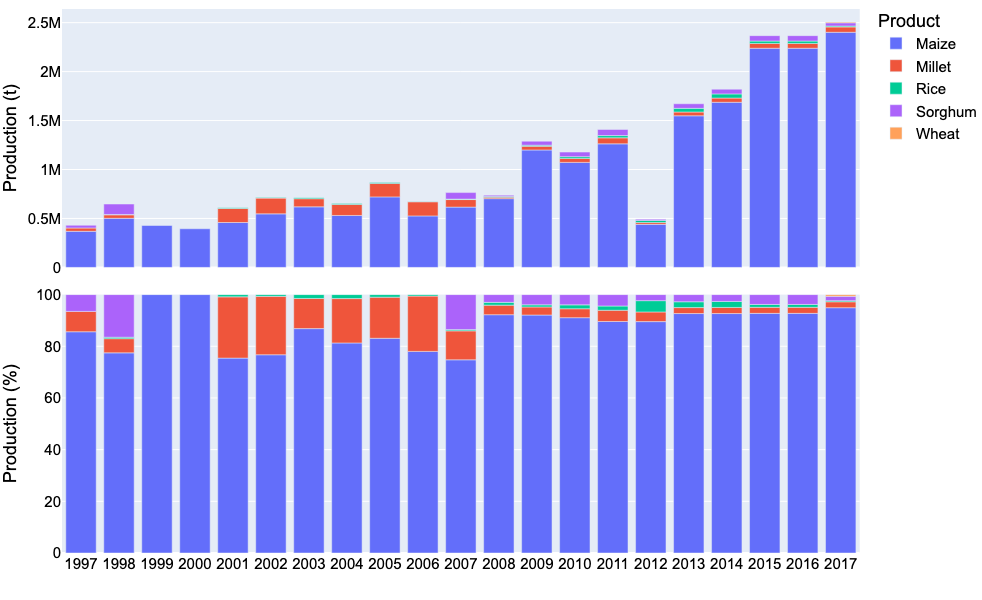

In [7]:
# Bar chart of national grain production
country_iso, country_name = 'AO', 'Angola'
df = pd.read_hdf('./data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_order = ['Maize', 'Millet', 'Rice','Sorghum']
for season_name in ['Main']:
    footnote = 'National grain production in %s - %s' % (country_name, season_name)
    fn_save = './figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    fig = PlotBarProduction(sub, year, product_order, footnote, fn_save)
    fig.show()

./figures/AO_line_pay_Millet_Main.png is saved.


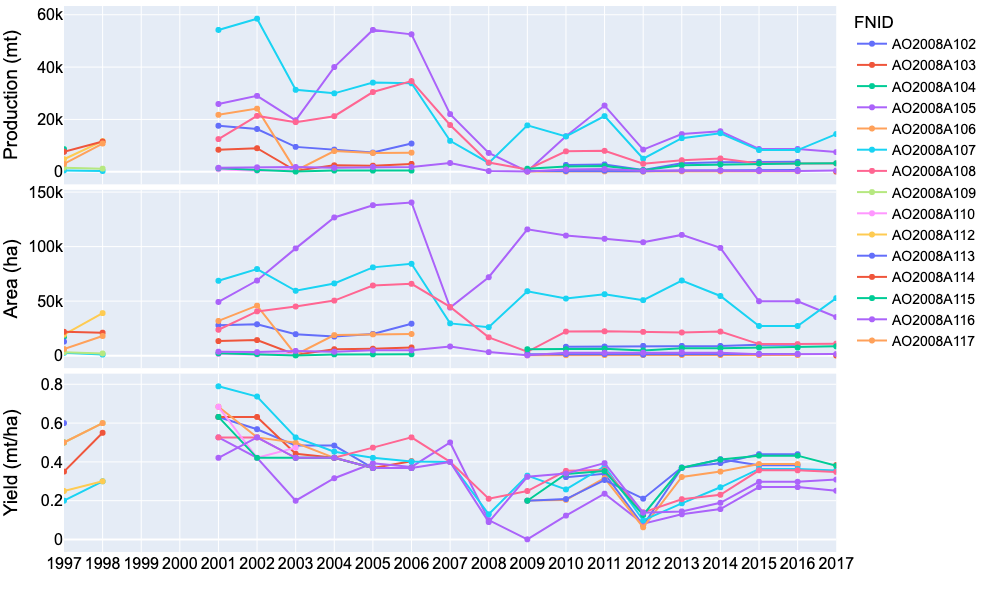

./figures/AO_line_pay_Sorghum_Main.png is saved.


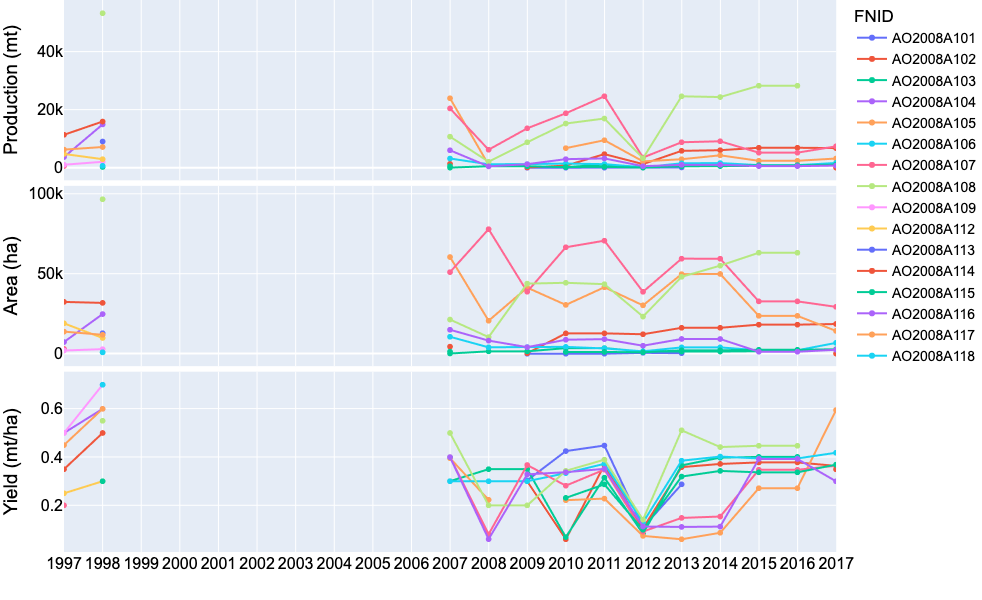

./figures/AO_line_pay_Maize_Main.png is saved.


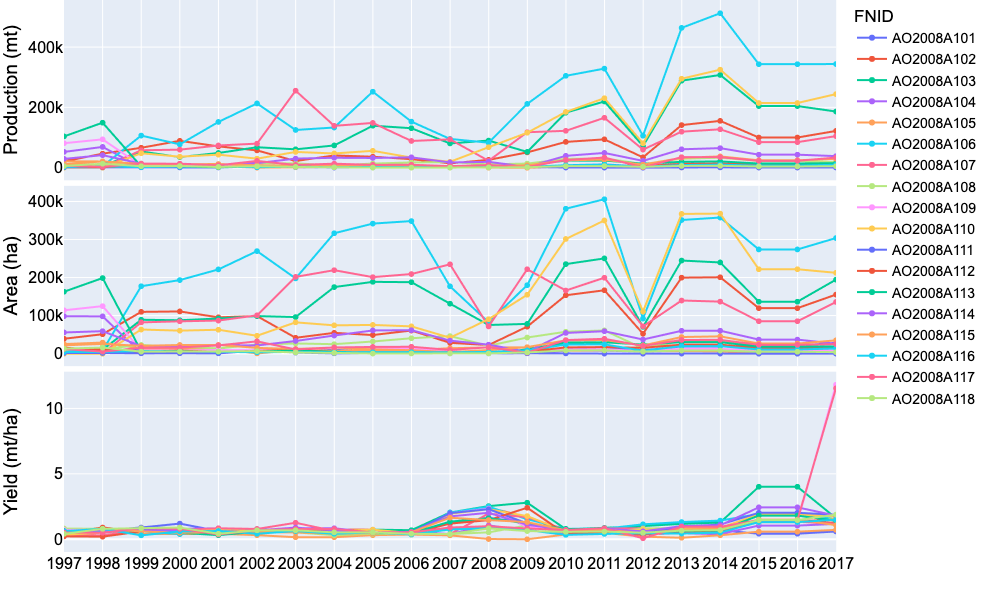

./figures/AO_line_pay_Rice_Main.png is saved.


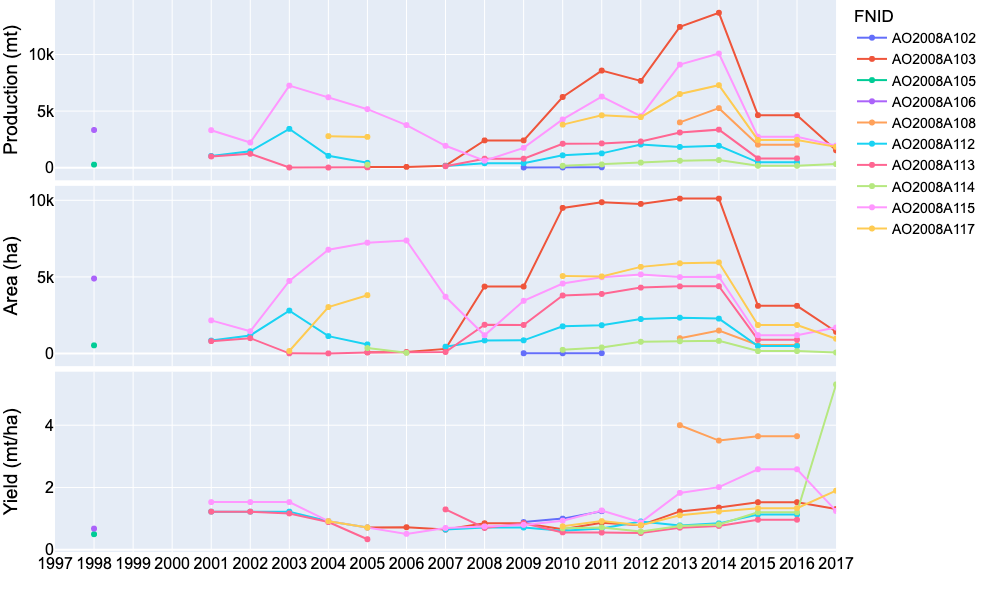

In [8]:
# Lineplot of Production-Area-Yield (PAY) time-series
country_iso, country_name = 'AO', 'Angola'
df = pd.read_hdf('./data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Millet','Main'],
    ['Sorghum','Main'],
    ['Maize','Main'],
    ['Rice','Main'],
]
for product_name, season_name in product_season:
    footnote = 'Production-Area-Yield (PAY) time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = './figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    fig = PlotLinePAY(sub, year, footnote, fn_save)
    fig.show()

In [9]:
# Calibrated PAY time-series per FNID
from tools_graphic import PlotLineCropTS
country_iso, country_name = 'AO', 'Angola'
df = pd.read_hdf('./data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; df['year'] = df['harvest_year']
link_ratio = load_npz('./data/crop/adm_crop_production_%s_ratio.npz' % country_iso)
year_all = np.arange(df['year'].min(), df['year'].max()+1)
product_season = [
    ['Millet','Main'],
    ['Sorghum','Main'],
    ['Maize','Main'],
    ['Rice','Main']
]
for product_name, season_name in product_season:
    sub = df[
        (df['product'] == product_name) &
        (df['season_name'] == season_name)
    ]
    for fnid in sub['fnid'].unique():
        sub_fps = sub[sub['fnid'] == fnid]
        fn_save = './figures/crop_calibrated/%s_%s_%s_%s.png' % (country_iso, product_name, season_name, fnid)
        fig = PlotLineCropTS(sub_fps, fnid, product_name, season_name, link_ratio, year_all, fn_save)

./figures/crop_calibrated/AO_Millet_Main_AO2008A102.png is saved.
./figures/crop_calibrated/AO_Millet_Main_AO2008A103.png is saved.
./figures/crop_calibrated/AO_Millet_Main_AO2008A106.png is saved.
./figures/crop_calibrated/AO_Millet_Main_AO2008A109.png is saved.
./figures/crop_calibrated/AO_Millet_Main_AO2008A110.png is saved.
./figures/crop_calibrated/AO_Millet_Main_AO2008A112.png is saved.
./figures/crop_calibrated/AO_Millet_Main_AO2008A113.png is saved.
./figures/crop_calibrated/AO_Millet_Main_AO2008A114.png is saved.
./figures/crop_calibrated/AO_Millet_Main_AO2008A115.png is saved.
./figures/crop_calibrated/AO_Millet_Main_AO2008A116.png is saved.
./figures/crop_calibrated/AO_Millet_Main_AO2008A117.png is saved.
./figures/crop_calibrated/AO_Millet_Main_AO2008A107.png is saved.
./figures/crop_calibrated/AO_Millet_Main_AO2008A104.png is saved.
./figures/crop_calibrated/AO_Millet_Main_AO2008A108.png is saved.
./figures/crop_calibrated/AO_Millet_Main_AO2008A105.png is saved.
./figures/

In [10]:
# Heatmap of seasonal data availability
country_iso, country_name = 'AO', 'Angola'
df = pd.read_hdf('./data/crop/adm_crop_production_%s_raw.hdf' % country_iso)
df['year'] = df['harvest_year']
code = {'Main':1}
comb = {1:1,10:2,11:3}
comb_name = {1:'Main season'}
for product_name in ['Sorghum','Millet','Maize (corn)']:
    fig = plt.figure()
    data = df[(df['product'] == product_name) & (df['season_name'].isin(code.keys()))]
    footnote = 'Seasonal data availability in %s - %s (uncorrected)' % (country_name, product_name)
    fn_save = './figures/%s_heat_seasondata_%s.png' % (country_iso, product_name)
    plt = PlotHeatSeasonData(data, code, comb, comb_name, footnote, fn_save)

NameError: name 'plt' is not defined